In [128]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
import pkg_resources
# necessary to unload the hcp preprocessed data
import h5py
import joblib
from scipy import stats
from sklearn.metrics import r2_score

# inhouse functions
# to generate pseudo-empirical data X = WX + E, with empirical randomized intrinsic noise E
import pseudoData 
# define a regression model for each node using its set of connected nodes
import featureSelectRegression
# a series of functions to run and read the PC algorithm output
import PCalgWrapper
# used for plotting activation matrices (see Figure 4 in Sanchez-Romero et al.(2023)
import plotActivations

import ActflowToolbox as actflow
import CombinedFC.CombinedFCToolBox as cfc

In [2]:
# hcp data cohort used for this analysis
# 176 participants
hcp_cohort = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832','154229','164939','175338','185139','194645','204622',
            '213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331',
            '154532','165638','175742','185341','195445','205119','213421','274542','341834',
            '393247','479762','545345','597869','664757','742549','820745','887373','989987',
            '102311','111009','118831','128632','135528','146432','154936','167036','176441',
            '186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932',
            '129028','135629','146533','156031','167440','176845','187850','196346','205826',
            '214423','285446','348545','395756','481042','553344','599671','675661','749058',
            '832651','899885','991267','102614','112920','119126','129129','135932','147636',
            '157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774',
            '103111','113316','120212','130013','136227','148133','157437','169545','178748',
            '188549','198451','208327','217429','290136','352738','414229','497865','559457',
            '615744','679770','753150','837560','907656','993675','103414','113619','120414',
            '130114','136833','150726','157942','171330']

In [3]:
# load the hcp resting state data and the activations by 24 task conditions
# from the h5 files in the hcpData directory
num_subjects = len(hcp_cohort)
num_regions = 360 # from the Glasser cortical parcellation
num_tasks = 24  # 24 task conditions
num_datapoints = 1195 # first run of the hcp data
#initialize arrays to save subject level data
rsbold_data = np.empty((num_regions,num_datapoints,num_subjects))
activation_data = np.empty((num_regions,num_tasks,num_subjects))

scount = 0
for subj in hcp_cohort:
    file_name = f'hcpData/{subj}_hcpData.h5'
    f = h5py.File(file_name, 'r')
    rsbold_data[:,:,scount] = f['rest_data']
    activation_data[:,:,scount] = f['activ_bycond']
    scount += 1

### Empirical data resting state functional connectivity (FC) and activity flow predictions

#### correlation

In [4]:
%%time
# correlation analysis of the resting-state data. Use combinedFC toolbox
#save FC matrices per subject
m_corr = np.empty((num_regions,num_regions,num_subjects))
# save activity flow predictions per region, per task, per subject
pred_act_corr = np.empty((num_regions,num_tasks,num_subjects))
# save running times to evaluate computational efficiency
time_corr = np.empty((num_subjects,))

for subj in range(num_subjects):
    start = time.time()
    # FC computation
    m_corr[:,:,subj] = cfc.correlationSig(rsbold_data[:,:,subj].T, alpha = 0.01)
    
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_corr[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj], m_corr[:,:,subj])
    
    # save running time
    time_corr[subj] = time.time() - start

print('- correlation FC matrices and activity flow predictions')
print(f'- for {num_regions} regions, {num_tasks} task conditions and {num_subjects} subjects')

- correlation FC matrices and activity flow predictions
- for 360 regions, 24 task conditions and 176 subjects
CPU times: user 1min 16s, sys: 51.6 s, total: 2min 8s
Wall time: 1min 3s


#### multiple regression
The next cell may take a lot of time to run serially (~2hrs).
We include a parallelization strategy below (mregForParallel)

In [ ]:
# we suggest to run the parallelization strategy from the cells below.

# multiple regression analysis of the resting-state data
m_mreg = np.empty((num_regions,num_regions,num_subjects))
pred_act_mreg = np.empty((num_regions,num_tasks,num_subjects))
time_mreg = np.empty((num_subjects,))

for subj in range(num_subjects):
    start = time.time()
    # FC computation
    m_mreg[:,:,subj] = cfc.multipleRegressionSig(rsbold_data[:,:,subj].T, alpha = 0.01, sigTest = True)
    
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_mreg[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj], m_mreg[:,:,subj])
    
    #save running time
    time_mreg[subj] = time.time() - start

print('- multiple regression FC matrices and activity flow predictions')
print(f'- for {num_regions} regions, {num_tasks} task conditions and {num_subjects} subjects')

#### multiple regression: parallelized per subject

In [ ]:
# function to run parallel per subject multiple regression FC inferences
def mregForParallel(subj,num_tasks):
    pred_act_mreg = np.empty((num_regions,num_tasks))
    start = time.time()
    m_mreg = cfc.multipleRegressionSig(rsbold_data[:,:,subj].T, alpha = 0.01, sigTest = True)
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_mreg[:,j] = actflow.actflowcalc(activation_data[:,j,subj], m_mreg)
    # save running time
    time_mreg = time.time() - start
    # save results per subject
    output_name = f'temp/subj_{subj}_mregResults.npz'
    np.savez_compressed(output_name, 
                        m_mreg = m_mreg, 
                        pred_act_mreg = pred_act_mreg,
                        time_mreg = time_mreg)

In [ ]:
%%time
# run mregForParallel using the joblib package
# num_tasks is defined in cell #3
# print number of cores available
print(f'{joblib.cpu_count()} cores')
joblib.Parallel(n_jobs=joblib.cpu_count())(
        joblib.delayed(mregForParallel)(subj, num_tasks) for subj in range(num_subjects))


print('- multiple regression FC matrices and activity flow predictions')
print(f'- for {num_regions} regions, {num_tasks} task conditions and {num_subjects} subjects')
print('- results files in temp/subj_#_mregResuts.npz')

In [ ]:
# unload the results of all the subjects to use them for the rest of the analysis.
m_mreg = np.empty((num_regions,num_regions,num_subjects))
pred_act_mreg = np.empty((num_regions,num_tasks,num_subjects))
time_mreg = np.empty((num_subjects,))

for subj in range(num_subjects):
    results = np.load(f'temp/subj_{subj}_mregResults.npz')
    m_mreg[:,:,subj] = results['m_mreg']
    pred_act_mreg[:,:,subj] = results['pred_act_mreg']
    time_mreg[subj] = results['time_mreg']

#### combinedFC

In [ ]:
%%time
#combinedFC with feature selection analysis of resting-state data X_rest
m_cfc =  np.empty((num_regions,num_regions,num_subjects))
pred_act_cfc = np.empty((num_regions,num_tasks,num_subjects))
time_cfc = np.empty((num_subjects,))

for subj in range(num_subjects):
    start = time.time()
    # FC computation
    data = rsbold_data[:,:,subj].T
    M_aux = cfc.combinedFC(data,
                         methodCondAsso = 'partialCorrelation',
                         alphaCondAsso = 0.01,
                         methodAsso = 'correlation',
                         alphaAsso = 0.01)
    
    m_cfc[:,:,subj] = featureSelectRegression.featureSelectRegression(M_aux, data, typ='symmetric')
    
    # activity flow calculation using activity flow toolbox    
    for j in range(num_tasks):
        pred_act_cfc[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj], m_cfc[:,:,subj])
    
    #save running time
    time_cfc[subj] = time.time() - start
    
print('- combinedFC FC matrices and activity flow predictions')
print(f'- for {num_regions} regions, {num_tasks} task conditions and {num_subjects} subjects')

#### PC algorithm: PC and PCadj
Running PC in serial order can take some hours and importantly
continuous runs of PC can freeze the system (not sure why). 
We suggest to parallelize per subject and save the results in files,
such that if the system stops it is not necessary to run everything again. 

##### function to parallelize

In [ ]:
# function to run parallel per subject PC algorithm FC inferences
def PCForParallel(subj,num_tasks):
    current_dir = os.getcwd()
    pred_act_PC = np.empty((num_regions,num_tasks))
    pred_act_PCadj = np.empty((num_regions,num_tasks))
    
    startPC = time.time()
    # FC computation
    # temporary save data for PC. The algorithm requires a txt file as input
    data = rsbold_data[:,:,subj].T
    input_data = f'{current_dir}/temp/data_s{subj}_temp.txt'
    np.savetxt(input_data, data, fmt='%0.6f', delimiter=',')
    # define output directory, output file name and Tetrad software path
    out_dir = f'{current_dir}/temp'
    out_name = f'PCgraph_temp_s{subj}'
    tetrad_path = f'{current_dir}/causal-cmd-1.1.3.variations/causal-cmd-1.1.3-jar-noMeekRules234.jar'
    # call PC
    PCalgWrapper.PCalgRun(input_data, out_dir, out_name, tetrad_path, alpha = 0.01)
    # transform the PC output graph into a numpy array
    PC_graph = PCalgWrapper.tetrad2matrix(f'{out_dir}/{out_name}.txt')
    # save the original PC output
    orig_PC = PC_graph
    time_search_PC = time.time() - startPC
    
    # Use the set of parents as regressors y = bPa(y) + e, to get a weighted directed matrix
    # refer as PC or PC algorithm in the paper
    start = time.time()
    m_PC = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='parents')
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_PC[:,j] = actflow.actflowcalc(activation_data[:,j,subj], m_PC)
    # running time is the PC search time + computation of weights time + actflowcalc    
    time_PC = (time.time() - start) + time_search_PC

    # Use the adjacencies of the PC results: y = bAdj(y) + e
    # refer as PCadj or PC adjacencies, in the paper
    start = time.time()
    m_PCadj = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='adjacencies')
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks): 
        pred_act_PCadj[:,j] = actflow.actflowcalc(activation_data[:,j,subj], m_PCadj)
    time_PCadj = (time.time() - start) + time_search_PC
    
    
    # save results per subject
    output_name = f'temp/subj_{subj}_PCResults.npz'
    np.savez_compressed(output_name, 
                        orig_PC = orig_PC, 
                        m_PCadj = m_PCadj, 
                        pred_act_PCadj = pred_act_PCadj,
                        time_PCadj = time_PCadj,
                        m_PC = m_PC, 
                        pred_act_PC = pred_act_PC,
                        time_PC = time_PC
                       )
    
    # delete the PC aux data and output txt files to save space
    os.remove(input_data)
    os.remove(f'{out_dir}/{out_name}.txt')

##### parallelized run

In [ ]:
%%time
# run pcForParallel using the joblib package
# num_tasks is defined in cell #3
# print number of cores available
print(f'{joblib.cpu_count()} cores')
joblib.Parallel(n_jobs=joblib.cpu_count())(
        joblib.delayed(PCForParallel)(subj, num_tasks) for subj in range(num_subjects))

print('- PC and PC-adjacencies FC matrices and activity flow predictions')
print(f'- for {num_regions} regions, {num_tasks} task conditions and {num_subjects} subjects')
print('- results files in temp/subj_#_PCResults.npz')

##### unload results of the parallelized run

In [ ]:
# unload the results of all the subjects to use them for the rest of the analysis.
m_PC = np.empty((num_regions,num_regions,num_subjects))
pred_act_PC = np.empty((num_regions,num_tasks,num_subjects))
time_PC = np.empty((num_subjects,))
m_PCadj = np.empty((num_regions,num_regions,num_subjects))
pred_act_PCadj = np.empty((num_regions,num_tasks,num_subjects))
time_PCadj = np.empty((num_subjects,))
orig_PC = np.empty((num_regions,num_regions,num_subjects))

for subj in range(num_subjects):
    results = np.load(f'temp/subj_{subj}_PCResults.npz')
    orig_PC[:,:,subj] = results['orig_PC']
    m_PC[:,:,subj] = results['m_PC']
    pred_act_PC[:,:,subj] = results['pred_act_PC']
    time_PC[subj] = results['time_PC']
    m_PCadj[:,:,subj] = results['m_PCadj']
    pred_act_PCadj[:,:,subj] = results['pred_act_PCadj']
    time_PCadj[subj] = results['time_PCadj']

### optional/auxiliary: save FC, actflow predictions and running times for empirical data
Uncomment to save or load FC, actflow predictions and running times

In [ ]:
'''
# save the results of the simulations: actflow predictions, FC estimates and running time
np.savez_compressed('predictions_empirical.npz',
                    actual = activation_data,
                    corr = pred_act_corr, 
                    mreg = pred_act_mreg,
                    cfc = pred_act_cfc,
                    PC = pred_act_PC,
                    PCadj = pred_act_PCadj
                   )
np.savez_compressed('connectivity_empirical.npz',
                       corr = m_corr,
                       mreg = m_mreg,
                       cfc = m_cfc,
                       PC = m_PC,
                       PCadj = m_PCadj,
                       orig_PC = orig_PC 
                       )
np.savez_compressed('time_empirical.npz',
                        corr = time_corr,
                        mreg = time_mreg,
                        cfc = time_cfc,
                        PC = time_PC,
                        PCadj = time_PCadj
                       )
'''

In [5]:
'''
# load the results of the simulations: actflow predictions, FC estimates and running time
# No need to run any of the previous cells
res = np.load('predictions_empirical.npz')
activation_data = res['actual']
pred_act_corr = res['corr']
pred_act_mreg = res['mreg']
pred_act_cfc = res['cfc']
pred_act_PC = res['PC']
pred_act_PCadj = res['PCadj']

res_m = np.load('connectivity_empirical.npz')
m_corr = res_m['corr']
m_mreg = res_m['mreg']
m_cfc = res_m['cfc']
m_PC = res_m['PC']
m_PCadj = res_m['PCadj']
#orig_PC = res_m['orig_PC']

res_time = np.load('time_empirical.npz')
time_corr = res_time['corr']
time_mreg = res_time['mreg']
time_cfc = res_time['cfc']
time_PC = res_time['PC']
time_PCadj = res_time['PCadj']

num_regions = activation_data.shape[0]
num_tasks = activation_data.shape[1]
num_subjects = activation_data.shape[2]
'''

### prediction accuracy of the actflow models parameterized with the different FC methods

In [121]:
# the output of this actflow toolbox function is a dictionary
# Output measures: Pearson correlation / R^2 coefficient of determination // MAE mean absolute error
# dict_keys(['corr_vals', 'R2_vals', 'mae_vals'])
# For each of the accuracy metrics the output is a 2D list: task conditions x number of subjects

# compute prediction accuracy of an activity flow model
# Input is a 3D activation array: region x task condition x subject
# computes the accuracy individually for each task condition across regions, per subject
corr_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_corr,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
mreg_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_mreg,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
cfc_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_cfc,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

PCadj_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_PCadj,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

PC_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_PC,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

### plot actflow models prediction accuracies
Refer to Figure 3A in Sanchez-Romero et al.(2023)

nodewise median prediction accuracy (r) across 24 task conditions and 176 subjects
 correlation   : 0.5668
 mul.reg       : 0.6011
 combinedFC    : 0.7733
 PC-adjacencies: 0.8190
 PC algorithm  : 0.7366


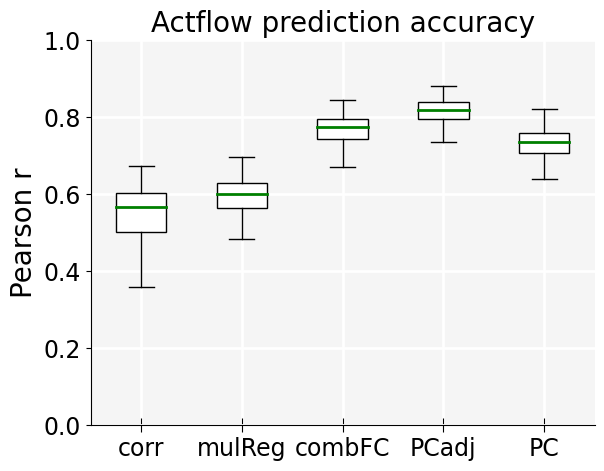

In [7]:
# choose Pearson r as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
# Accuracies are first averaged across task conditions
corr_acc_conditionAvg = np.mean(corr_acc['corr_vals'],axis=0)
mreg_acc_conditionAvg = np.mean(mreg_acc['corr_vals'],axis=0)
cfc_acc_conditionAvg = np.mean(cfc_acc['corr_vals'],axis=0)
PCadj_acc_conditionAvg = np.mean(PCadj_acc['corr_vals'],axis=0)
PC_acc_conditionAvg = np.mean(PC_acc['corr_vals'],axis=0)

# consolidate results for bar plotting
results_prediction = [corr_acc_conditionAvg,
                      mreg_acc_conditionAvg,
                      cfc_acc_conditionAvg,
                      PCadj_acc_conditionAvg,
                      PC_acc_conditionAvg]
# print median precision across subjects for each method
print(f'nodewise median prediction accuracy (r) across {num_tasks} task conditions and {num_subjects} subjects')
print(f' correlation   : {np.median(corr_acc_conditionAvg):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_prediction,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(color='green',linewidth=2)
plt.title('Actflow prediction accuracy', fontsize=20)
plt.ylabel('Pearson r',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalPredictionAccuracy.pdf',bbox_inches='tight')

### compare prediction accuracy with coefficient of determination R^2

In [8]:
# choose coefficient of determination R^2 as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
# Accuracies are first averaged across task conditions
# print median precision across subjects for each method
# choose Pearson r as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
corr_acc_conditionAvg_R2 = np.mean(corr_acc['R2_vals'],axis=0)
mreg_acc_conditionAvg_R2 = np.mean(mreg_acc['R2_vals'],axis=0)
cfc_acc_conditionAvg_R2 = np.mean(cfc_acc['R2_vals'],axis=0)
PCadj_acc_conditionAvg_R2 = np.mean(PCadj_acc['R2_vals'],axis=0)
PC_acc_conditionAvg_R2 = np.mean(PC_acc['R2_vals'],axis=0)

# print median precision across subjects for each method
print(f'nodewise median prediction accuracy (R^2) across {num_tasks} task conditions and {num_subjects} subjects')
print(f' correlation   : {np.median(corr_acc_conditionAvg_R2):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg_R2):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg_R2):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg_R2):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg_R2):.4f}')

nodewise median prediction accuracy (R^2) across 24 task conditions and 176 subjects
 correlation   : -709.7629
 mul.reg       : 0.3308
 combinedFC    : 0.5934
 PC-adjacencies: 0.6663
 PC algorithm  : 0.5321


### plot number of predictors for activity flow prediction
Refer to Figure 3B in Sanchez-Romero et al.(2023)

In [9]:
# number of predictors for to-be-predicted target region
# the more predictors (sources), the more complex, and less tractable is the predictive model
def numPredictors(inferred_model):
    num_subjects = inferred_model.shape[2]
    num_predictors = np.empty((num_subjects))
    for subj in range(num_subjects):
        #average of number of sources across all the regions in the inferred network
        num_predictors[subj] = np.mean(np.sum(inferred_model[:,:,subj]!=0,axis=1))   
    return num_predictors

median number of predictors across 176 repetitions
 correlation   : 253.38
 mul.reg       : 10.26
 combinedFC    : 8.43
 PC-adjacencies: 6.24
 PC algorithm  : 3.12


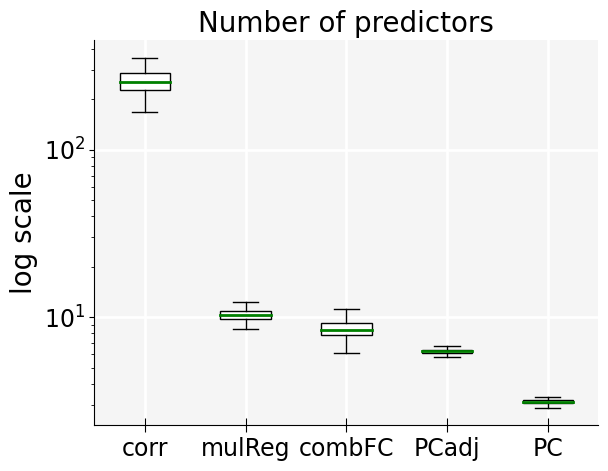

In [10]:
# define average number of predictors for each method, for the inferred FC network
corr_numPredictors = numPredictors(m_corr)
mreg_numPredictors = numPredictors(m_mreg)
cfc_numPredictors = numPredictors(m_cfc)
PCadj_numPredictors = numPredictors(m_PCadj)
PC_numPredictors = numPredictors(m_PC)
# consolidate results for bar plot
results_numPredictors = [corr_numPredictors,
                         mreg_numPredictors, 
                         cfc_numPredictors, 
                         PCadj_numPredictors, 
                         PC_numPredictors]
# print median number of predictors across subjects for each method
print(f'median number of predictors across {num_subjects} repetitions')
print(f' correlation   : {np.median(corr_numPredictors):.2f}')
print(f' mul.reg       : {np.median(mreg_numPredictors):.2f}')
print(f' combinedFC    : {np.median(cfc_numPredictors):.2f}')
print(f' PC-adjacencies: {np.median(PCadj_numPredictors):.2f}')
print(f' PC algorithm  : {np.median(PC_numPredictors):.2f}')

# plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_numPredictors,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(color='green',linewidth=2)
plt.title('Number of predictors',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.yscale('log')
plt.ylabel('log scale', fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalNumberOfPredictors_log.pdf',bbox_inches='tight')

### plot running times
Refer to Figure 3C in Sanchez-Romero et al.(2023)

median running time (sec) across 176 repetitions
 correlation   : 0.3612
 mul.reg       : 25.4072
 combinedFC    : 0.7919
 PC-adjacencies: 72.5214
 PC algorithm  : 72.4017


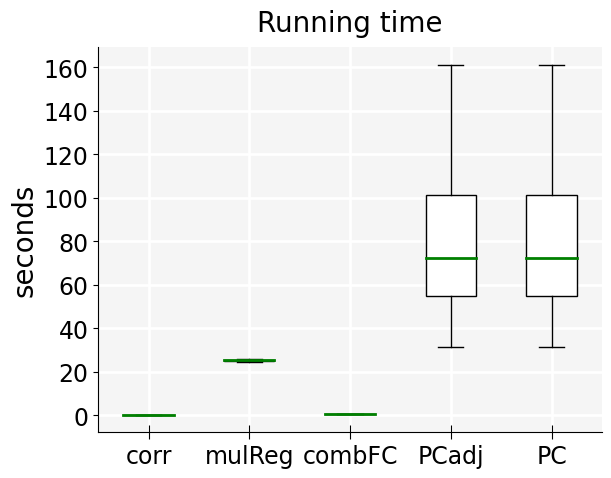

In [11]:
# consolidate results for barplots
results_time = [time_corr, time_mreg, time_cfc,time_PCadj,time_PC]
# print median running times across repetitions for each method
print(f'median running time (sec) across {num_subjects} repetitions')
print(f' correlation   : {np.median(time_corr):.4f}')
print(f' mul.reg       : {np.median(time_mreg):.4f}')
print(f' combinedFC    : {np.median(time_cfc):.4f}')
print(f' PC-adjacencies: {np.median(time_PCadj):.4f}')
print(f' PC algorithm  : {np.median(time_PC):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_time,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(color='green',linewidth=2)
plt.title('Running time',fontsize=20,y=1.02)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylabel('seconds',fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalRunningTimes.pdf', bbox_inches='tight')

### plot FC connectivity matrices
Refer to Figure 3D-H in Sanchez-Romero et al.(2023)

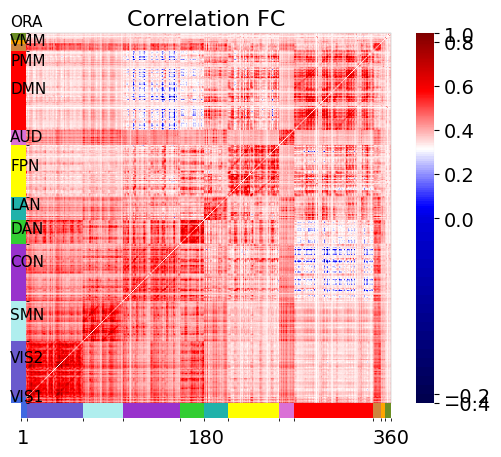

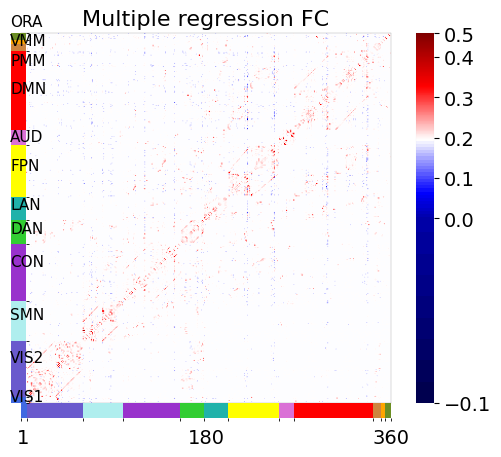

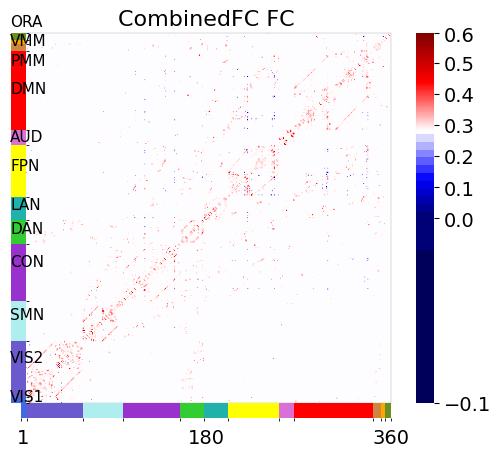

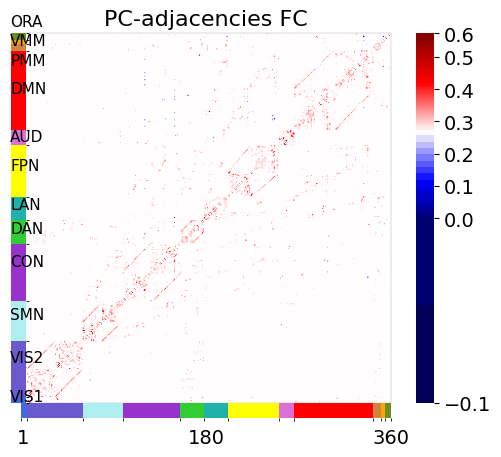

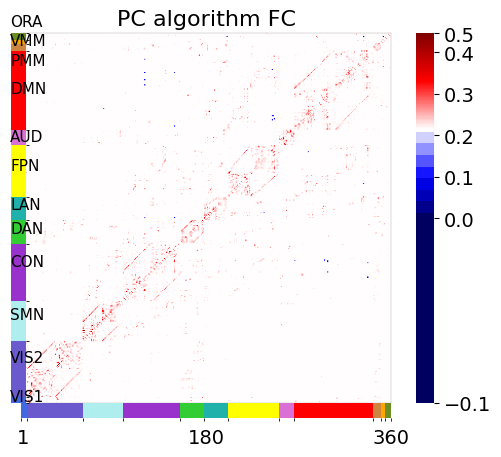

In [12]:
mat = m_corr
# plot average across subjects
mat = np.mean(mat,axis=2)
# threshold the plot for values +/- 0.005
m = abs(mat) > 0.005
mat = np.multiply(mat,m)
# use the combinedFC toolbox plotting functions
fig = cfc.plotConnectivityMatrix(mat,
                           methodTitle='Correlation FC',
                           functionalNetworks = True,
                           networkColorBar_x = True,
                           networkColorBar_y = True,
                           networkLabels = True,
                           )
# uncomment to save plot as pdf
#plt.savefig('EmpiricalCorrelationFC.pdf', bbox_inches='tight')

mat = m_mreg
mat = np.mean(mat,axis=2)
m = abs(mat) > 0.005
mat = np.multiply(mat,m)
fig = cfc.plotConnectivityMatrix(mat,
                           methodTitle='Multiple regression FC',
                           functionalNetworks = True,
                           networkColorBar_x = True,
                           networkColorBar_y = True,
                           networkLabels = True,
                           )
# uncomment to save plot as pdf
#plt.savefig('EmpiricalMultipleRegressionFC.pdf', bbox_inches='tight')

mat = m_cfc
mat = np.mean(mat,axis=2)
m = abs(mat) > 0.005
mat = np.multiply(mat,m)
fig = cfc.plotConnectivityMatrix(mat,
                           methodTitle='CombinedFC FC',
                           functionalNetworks = True,
                           networkColorBar_x = True,
                           networkColorBar_y = True,
                           networkLabels = True,
                           )
# uncomment to save plot as pdf
#plt.savefig('EmpiricalCombinedFCFC.pdf', bbox_inches='tight')

mat = m_PCadj
mat = np.mean(mat,axis=2)
m = abs(mat) > 0.005
mat = np.multiply(mat,m)
fig = cfc.plotConnectivityMatrix(mat,
                           methodTitle='PC-adjacencies FC',
                           functionalNetworks = True,
                           networkColorBar_x = True,
                           networkColorBar_y = True,
                           networkLabels = True,
                           )
# uncomment to save plot as pdf
#plt.savefig('EmpiricalPCalgorithmFC.pdf', bbox_inches='tight')

mat = m_PC
mat = np.mean(mat,axis=2)
m = abs(mat) > 0.005
mat = np.multiply(mat,m)
fig = cfc.plotConnectivityMatrix(mat,
                           methodTitle='PC algorithm FC',
                           functionalNetworks = True,
                           networkColorBar_x = True,
                           networkColorBar_y = True,
                           networkLabels = True,
                           )
# uncomment to save plot as pdf
#plt.savefig('EmpiricalPCadjacenciesFC.pdf', bbox_inches='tight')

### sparsity matching analysis
Compare FC methods by first matching their sparsity to that of PCadj. This controls for the effect of sparsity. 
Refer to end of section Results 3.3 in Sanchez-Romero et al.(2023)

In [68]:
# function to perform sparsity matching analysis
def sparsityMatching(matrix_o, matrix_t):  
    # for each repetition individually
    # this procedure equates the spartsity (number of edges) of matrix_t to that of matrix_o (reference)
    num_repetitions = np.shape(matrix_o)[2]
    num_nodes = np.shape(matrix_o)[0]
    #save the adjusted matrix here
    matrix_adj = np.zeros((num_nodes,num_nodes,num_repetitions))

    for rep in range(num_repetitions):
        aux = np.zeros((num_nodes,num_nodes))
        # compute the number of edges in matrix_o
        # divide by two because the matrix is symmetric, so M[i,j] and M[j,i] represent the same edge
        num_edges = (np.sum(np.sum(matrix_o[:,:,rep]!=0,axis=1))/2).astype(int)
        # in mulreg and cfc, the matrix is symmetric edgewise but not coefficientwise,
        # so for each edge choose the max absolute weight and put it in the upper triangular
        # then select the n max values of the upper triangular, where n = num_edges
        for x in range(num_nodes-1):
            for y in range(x+1,num_nodes):
                aux[x,y] = np.max((np.abs(matrix_t[x,y,rep]),np.abs(matrix_t[y,x,rep])))

        # easier to work with flattened arrays
        aux = aux.flatten()
        # index of larger to smaller edge coefficient
        idx = np.flip(np.argsort(aux,kind = 'stable'))
        # keep n max values and make zero all other, where n = num_edges 
        aux[idx[num_edges:]] = 0
        # reshape to a node x node matrix
        aux = np.reshape(aux,(num_nodes,num_nodes))
        # make a binary mask, where 1s imply selected edges
        a = aux!=0
        # make the mask symmetric
        mask = a + a.T
        # apply the mask to recover the original values of matrix_t
        matrix_adj[:,:,rep] = np.multiply(matrix_t[:,:,rep],mask) 

    return matrix_adj

In [71]:
# compute the sparsity matching FC matrices
m_corr_sparse = sparsityMatching(m_PCadj,m_corr)
m_mreg_sparse = sparsityMatching(m_PCadj,m_mreg)
m_cfc_sparse = sparsityMatching(m_PCadj,m_cfc)

In [73]:
# compute the actflow predictions with the new sparse FC models
pred_act_corr_sparse = np.empty((num_regions,num_tasks,num_subjects))
pred_act_mreg_sparse = np.empty((num_regions,num_tasks,num_subjects))
pred_act_cfc_sparse = np.empty((num_regions,num_tasks,num_subjects))

for subj in range(num_subjects):
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_corr_sparse[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj],
                                                             m_corr_sparse[:,:,subj])
        pred_act_mreg_sparse[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj],
                                                             m_mreg_sparse[:,:,subj])
        pred_act_cfc_sparse[:,j,subj] = actflow.actflowcalc(activation_data[:,j,subj],
                                                             m_cfc_sparse[:,:,subj])

In [74]:
# compute the actflow prediction accuracies per node, task, subject
corr_acc_sparse = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_corr_sparse,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
mreg_acc_sparse = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_mreg_sparse,
                                          comparison_type = 'nodewise_compthenavg'
                                          )
cfc_acc_sparse = actflow.model_compare_predicted_to_actual(
                                          target_actvect = activation_data,
                                          pred_actvect = pred_act_cfc_sparse,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

In [95]:
# Accuracies are first averaged across task conditions
corr_acc_conditionAvg_sparse = np.mean(corr_acc_sparse['corr_vals'],axis=0)
mreg_acc_conditionAvg_sparse = np.mean(mreg_acc_sparse['corr_vals'],axis=0)
cfc_acc_conditionAvg_sparse = np.mean(cfc_acc_sparse['corr_vals'],axis=0)
# print median precision across subjects for each method
print(f'for FC sparsity matching analysis')
print(f'nodewise median prediction accuracy (r) across {num_tasks} task conditions and {num_subjects} subjects')
print(f' correlation   : {np.median(corr_acc_conditionAvg_sparse):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg_sparse):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg_sparse):.4f}')

print(f'')
print('Test if FC sparsity-matched actflow prediction accuracy (r) < FC actflow prediction accuracy (r)')
print('correlation')
print(stats.ttest_ind(corr_acc_conditionAvg_sparse, corr_acc_conditionAvg, equal_var=False,alternative='less'))
print('multiple regression')
print(stats.ttest_ind(mreg_acc_conditionAvg_sparse, mreg_acc_conditionAvg, equal_var=False,alternative='less'))
print('combinedFC')
print(stats.ttest_ind(cfc_acc_conditionAvg_sparse, cfc_acc_conditionAvg, equal_var=False,alternative='less'))

for FC sparsity matching analysis
nodewise median prediction accuracy (r) across 24 task conditions and 176 subjects
 correlation   : 0.4830
 mul.reg       : 0.5319
 combinedFC    : 0.7733

Test if FC sparsity-matched actflow prediction accuracy (r) < FC actflow prediction accuracy (r)
correlation
Ttest_indResult(statistic=-9.865401708394364, pvalue=1.2638354645544149e-20)
multiple regression
Ttest_indResult(statistic=-14.080260666515246, pvalue=2.7575817018020402e-36)
combinedFC
Ttest_indResult(statistic=-0.2226582623941008, pvalue=0.41196569026423985)


In [94]:
# Accuracies are first averaged across task conditions
corr_acc_conditionAvg_sparse_R2 = np.mean(corr_acc_sparse['R2_vals'],axis=0)
mreg_acc_conditionAvg_sparse_R2 = np.mean(mreg_acc_sparse['R2_vals'],axis=0)
cfc_acc_conditionAvg_sparse_R2 = np.mean(cfc_acc_sparse['R2_vals'],axis=0)
# print median precision across subjects for each method
print(f'')
print(f'for FC sparsity matching analysis')
print(f'nodewise median prediction accuracy (R^2) across {num_tasks} task conditions and {num_subjects} subjects')
print(f' correlation   : {np.median(corr_acc_conditionAvg_sparse_R2):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg_sparse_R2):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg_sparse_R2):.4f}')

print(f'')
print('Test if FC sparsity-matched actflow prediction accuracy (R^2) < FC actflow prediction accuracy (R^2)')
print('correlation')
print(stats.ttest_ind(corr_acc_conditionAvg_sparse_R2, corr_acc_conditionAvg_R2, equal_var=False,alternative='less'))
print('multiple regression')
print(stats.ttest_ind(mreg_acc_conditionAvg_sparse_R2, mreg_acc_conditionAvg_R2, equal_var=False,alternative='less'))
print('combinedFC')
print(stats.ttest_ind(cfc_acc_conditionAvg_sparse_R2, cfc_acc_conditionAvg_R2, equal_var=False,alternative='less'))


for FC sparsity matching analysis
nodewise median prediction accuracy (R^2) across 24 task conditions and 176 subjects
 correlation   : -33.0766
 mul.reg       : 0.2310
 combinedFC    : 0.5927

Test if FC sparsity-matched actflow prediction accuracy (R^2) < FC actflow prediction accuracy (R^2)
correlation
Ttest_indResult(statistic=12.754984306121376, pvalue=1.0)
multiple regression
Ttest_indResult(statistic=-13.362829758505592, pvalue=1.7232617484635603e-33)
combinedFC
Ttest_indResult(statistic=-0.32718894457966896, pvalue=0.3718603141492839)


### plot task-evoked activations: regions x task conditions
Refer to Figure 4A-C in Sanchez-Romero et al.(2023)

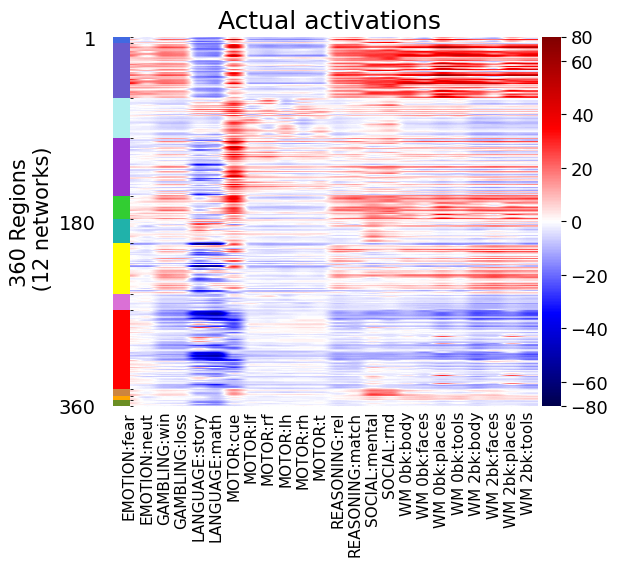

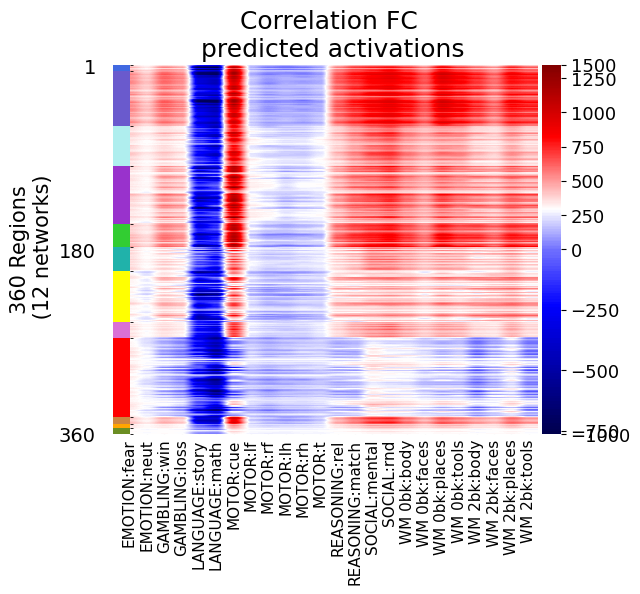

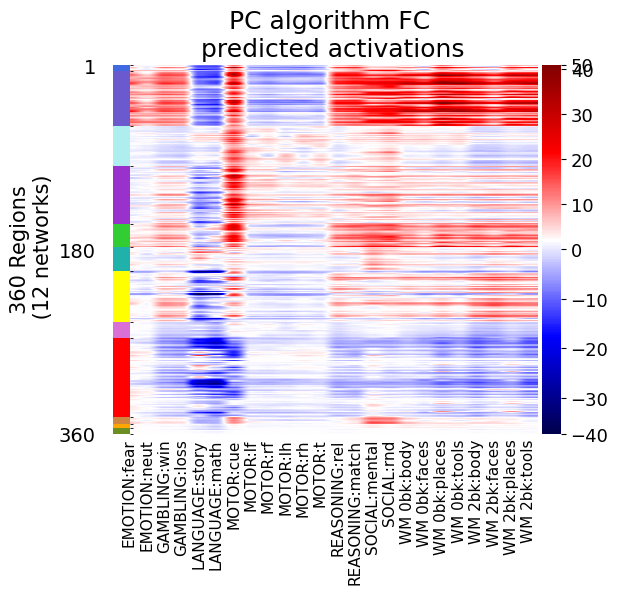

In [24]:
act_subjectMedian = np.median(activation_data,axis=2)
plotActivations.plotActivations(act_subjectMedian,'Actual activations',
                        functional_networks=True, no_ylabel=False, network_color_bar=True)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalActualActivations.pdf', bbox_inches='tight')


act_subjectMedian = np.median(pred_act_corr,axis=2)
plotActivations.plotActivations(act_subjectMedian,'Correlation FC\n predicted activations',
                        functional_networks=True, no_ylabel=False, network_color_bar=True)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalCorrelationFCPredictedActivations.pdf', bbox_inches='tight')

act_subjectMedian = np.median(pred_act_PC,axis=2)
plotActivations.plotActivations(act_subjectMedian,'PC algorithm FC\n predicted activations',
                        functional_networks=True, no_ylabel=False, network_color_bar=True)
# uncomment to save plot as pdf
#plt.savefig('EmpiricalCorrelationFCPredictedActivations.pdf', bbox_inches='tight')

### motor:lh (left hand) and working memory 2bk:places analysis
Refer to Figure 4D-I in Sanchez-Romero et al.(2023)

In [114]:
print('median across the 176 subjects')
print(f'condition {9+1}: MOTOR:lh')

c = corr_acc['corr_vals']
p = PC_acc['corr_vals']
print(f'correlation-FC actflow predictions r: {np.median(c[9])}')
print(f'PC-FC actflow predictions r: {np.median(p[9])}')
print('')
c = corr_acc['R2_vals']
p = PC_acc['R2_vals']
print(f'correlation-FC actflow predictions R2: {np.median(c[9])}')
print(f'PC-FC actflow predictions R2: {np.median(p[9])}')
print('')

median across the 176 subjects
condition 10: MOTOR:lh
correlation-FC actflow predictions R2: -352.7062435699677
PC-FC actflow predictions R2: 0.4046573660237672

correlation-FC actflow predictions r: 0.4685128432992747
PC-FC actflow predictions r: 0.6424751948888336


In [116]:
print('median across the 176 subjects')
print(f'condition {22+1}: WM 2bk:places')
c = corr_acc['corr_vals']
p = PC_acc['corr_vals']
print(f'correlation-FC actflow predictions r: {np.median(c[22])}')
print(f'PC-FC actflow predictions r: {np.median(p[22])}')
print('')
c = corr_acc['R2_vals']
p = PC_acc['R2_vals']
print(f'correlation-FC actflow predictions R2: {np.median(c[22])}')
print(f'PC-FC actflow predictions R2: {np.median(p[22])}')

median across the 176 subjects
condition 23: WM 2bk:places
correlation-FC actflow predictions r: 0.5694131303796559
PC-FC actflow predictions r: 0.7786870135943924

correlation-FC actflow predictions R2: -481.13452816086146
PC-FC actflow predictions R2: 0.584709430294614


### condition-wise accuracy comparison of activity flow predictions for 360 cortical regions, PC-FC vs. corr-FC
Refer to Figure 5 from Sanchez-Romero et al.(2023)

In [129]:
# compute accuracy condition-wise
# for each region i, the vectors of actual and predicted activations comprise the 24 task conditions.
# compute Pearson r and R2 as measures of accuracy
# we are interested in testing for each region if PC-FC actflow accuracy > corr-FC actflow accuracy
# ie. PC-FC-actflow-prediction - corr-FC-actflow-prediction > 0 
accu_diff_r = np.zeros((num_regions,num_subjects))
accu_diff_R2 = np.zeros((num_regions,num_subjects))

# loop across regions
for r in range(num_regions):
    # loop across subjects
    for s in range(num_subjects):
        # vectors of comparison
        # load the actual and the predicted activations for all 24 conditions
        actual = activation_data[r,:,s]
        corr_pred = pred_act_corr[r,:,s]
        pc_pred   = pred_act_PC[r,:,s]
        
        # compute the prediction accuracy using Pearson correlation
        if not np.sum(pc_pred)==0 and not np.sum(corr_pred) == 0:
            # compute Pearson r accuracy
            a = np.corrcoef(actual,pc_pred)[0,1]
            b = np.corrcoef(actual,corr_pred)[0,1]
            # PC-FC-actflow-prediction - corr-FC-actflow-prediction
            accu_diff_r[r,s] = a - b
            
            # compute R2 accuracy
            a = r2_score(actual,pc_pred)
            b = r2_score(actual,corr_pred)
            # PC-FC-actflow-prediction - corr-FC-actflow-prediction
            accu_diff_R2[r,s] = a - b

In [142]:
# for each region test if PC-FC actflow accuracy > corr-FC actflow accuracy
# use permutation multiple comparison method: max-t from Nichols and Holmes (2002) to adjust p-values
print('significance of PC-FC actflow accuracy > corr-FC actflow accuracy for each region')
print(f'')
# for Pearson accuracy
maxt_output = max_t.max_t(np.array(accu_diff_r),tail=1)
#p-values
alpha = 0.01
maxt_sigvector = maxt_output[2] < alpha
print('for accuracy Pearson r')
print(f'Percent significant regions (maxT corrected for multiple comparisons, p < {alpha}): {100*np.sum(maxt_sigvector)/360:4f}%')

print(f'')
# for R2 accuracy
maxt_output = max_t.max_t(np.array(accu_diff_R2),tail=1)
#p-values
alpha = 0.01
maxt_sigvector = maxt_output[2] < alpha
print('for accuracy R2')
print(f'Percent significant regions (maxT corrected for multiple comparisons, p < {alpha}): {100*np.sum(maxt_sigvector)/360:4f}%')

significance of PC-FC actflow accuracy > corr-FC actflow accuracy for each region

for accuracy Pearson r
Percent significant regions (maxT corrected for multiple comparisons, p < 0.01): 82.222222%

for accuracy R2
Percent significant regions (maxT corrected for multiple comparisons, p < 0.01): 99.444444%


### working memory 2-back vs 0-back contrast analysis
Refer to Figure 6 from Sanchez-Romero et al.(2023)

In [30]:
# selection of ROI: right DLPFC Area 8C of Glasser et al. parcellation
target_roi = 253-1

In [40]:
# actual activations and contrast
conds_0back = np.arange(16,20)
conds_2back = np.arange(20,24)
#mean across the 4 n-back conditions
act = activation_data.copy()
activations_2back = np.mean(act[:,conds_2back,:],axis=1)
activations_0back = np.mean(act[:,conds_0back,:],axis=1)
#contrast: 2-back - 0-back
#contrast is [regions x subjects]
actual_contrast = np.subtract(activations_2back,activations_0back)
#plt.hist(np.mean(contrast,axis=1))
print(actual_contrast.shape)  # roi x subjects
# just for the ROI of interest
# mean contrast across subjects
# test of significance for mean contrast != 0, ie 2back-act != 0back-act
print('actual contrast')
print(np.mean(actual_contrast[target_roi,:]))
print(stats.ttest_1samp(actual_contrast[target_roi,:],0.0,alternative='two-sided'))

(360, 176)
actual contrast
8.264978088822152
TtestResult(statistic=14.58370092813882, pvalue=4.8101441243007914e-32, df=175)


#### analysis for correlation-FC

In [53]:
# get actflow estimates for the to-be-predicted region (FC_ij X Aj) for target region i
# where Aj are the actual contrast obtained in the above cell
conn_vect = m_corr[target_roi,:,:]
#compute the activity flow for each subject, and the effect of each region individually
actflow_estimates_corr = np.zeros((num_regions,num_subjects))
for s in range(num_subjects):
    actflow_estimates_corr[:,s] = np.multiply(conn_vect[:,s],actual_contrast[:,s])
print(actflow_estimates_corr.shape)

# cross-subject significance of Ho: Actflow predictions of the contrast for target region i != from 0
# 2-back - 0-back != 0 (if, then task conditions produce different cognitive effects)
# Actflow predictions by subject (1 x 176): sum of actflow estimates sum(FC_ij X Aj) across regions j
actflow_prediction_corr = np.sum(actflow_estimates_corr,axis=0)
print(f'corr-FC actflow predicted contrast for target region')
print(np.mean(actflow_prediction_corr))
print(stats.ttest_1samp(actflow_prediction_corr,0.0,alternative='two-sided'))

(360, 176)
corr-FC actflow predicted contrast for target region
52.219591470389304
TtestResult(statistic=3.5051697277621816, pvalue=0.0005795874446731986, df=175)


#### analysis for PC-FC

In [54]:
# get actflow estimates for the to-be-predicted region (FC_ij X Aj) for target region i
# where Aj are the actual contrast obtained in the above cell
conn_vect = m_PC[target_roi,:,:]
#compute the activity flow for each subject, and the effect of each region individually
actflow_estimates_PC = np.zeros((num_regions,num_subjects))
for s in range(num_subjects):
    actflow_estimates_PC[:,s] = np.multiply(conn_vect[:,s],actual_contrast[:,s])
print(actflow_estimates_PC.shape)

# cross-subject significance of Ho: Actflow predictions of the contrast for target region i != from 0
# 2-back - 0-back != 0 (if, then task conditions produce different cognitive effects)
# Actflow predictions by subject (1 x 176): sum of actflow estimates sum(FC_ij X Aj) across regions j
actflow_prediction_PC = np.sum(actflow_estimates_PC,axis=0)
print(f'PC-FC actflow predicted contrast for target region')
print(np.mean(actflow_prediction_PC))
print(stats.ttest_1samp(actflow_prediction_PC,0.0,alternative='two-sided'))

(360, 176)
PC-FC actflow predicted contrast for target region
5.462105356647368
TtestResult(statistic=12.439746995660887, pvalue=7.350498697253081e-26, df=175)


In [55]:
abs_error_corr = np.abs(actflow_prediction_corr - actual_contrast[target_roi,:])
abs_error_PC = np.abs(actflow_prediction_PC - actual_contrast[target_roi,:])
# mean absolute error (MAE) of the actflow prediction, comparison corr vs. pc
print(stats.wilcoxon(abs_error_corr, abs_error_PC, alternative='greater'))

WilcoxonResult(statistic=15560.0, pvalue=8.14741126550929e-31)


####  relevant contributing regions to the PC-based actflow DLPFC prediction (target region)
Refer to Table 2 in Sanchez-Romero et al.(2023)

In [151]:
#1. get average of roi actflow estimate (FCij x Aj) across subjects
afe = actflow_estimates_PC.copy()
print(afe.shape)
roi_mean = np.mean(afe,axis=1)
# get the absolute value to consider both positive and negative estimates
roi_mean_abs = np.abs(np.mean(afe,axis=1))

#2. get the top 95% percentile
p = 95
percentile = np.percentile(roi_mean_abs, p)
print(f'{p} percentile absolute value = {percentile}')
per_roi_idx = np.where(roi_mean_abs > percentile)[0]
# for reporting get the original estimate value, not the absolute value
per_roi_value = roi_mean[per_roi_idx]

#3. also report the networks to which these rois belong
orderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
network_partition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
network_def = np.loadtxt(network_partition_dir + '/cortex_parcel_network_assignments.txt')

print(f'{p} percentile top ROIs actflow estimates')
n = 1
for c in range(len(per_roi_idx)):
    r = per_roi_idx[c]
    net = orderedNetworks[int(network_def[r]-1)] #-1 due to Python 0 indexing
    
    print(f'{n}. roi {r} ({net}) = {per_roi_value[c]}')
    n = n+1
print('')
print('Warning! the roi indices start in 0.')
print('Add +1 before looking up roi name in Glasser et al.')

(360, 176)
95 percentile absolute value = 0.04062473280011053
95 percentile top ROIs actflow estimates
1. roi 72 (FPN) = 0.3394170549924686
2. roi 170 (FPN) = 0.05074116107630208
3. roi 242 (FPN) = 0.6863841106638545
4. roi 246 (DMN) = 0.8435394749509243
5. roi 250 (DMN) = 0.07665512820516111
6. roi 253 (FPN) = 0.08273270414587063
7. roi 256 (FPN) = 0.13060554972138883
8. roi 259 (FPN) = 0.08734401488540963
9. roi 260 (FPN) = 0.06801262384445737
10. roi 262 (FPN) = 0.5873788870170406
11. roi 264 (FPN) = 0.0447566208716535
12. roi 276 (FPN) = 0.22111584749066424
13. roi 277 (FPN) = 0.05761373353772164
14. roi 290 (FPN) = 0.059503729184122806
15. roi 324 (FPN) = 0.07536840530064297
16. roi 328 (FPN) = 1.5960301934179164
17. roi 330 (DMN) = 0.10323063901410583
18. roi 349 (FPN) = 0.08635906203194788

Warning! the roi indices start in 0.
Add +1 before looking up roi name in Glasser et al.


#### comparison of inter-subject variance explained for the 2-back vs 0-back WM contrast
Refer to end of section Results 3.6 in Sanchez-Romero et al.(2023)

In [154]:
print('inter-subject variance explained by actflow models for DLPFC target region')
print('')
print('PC-FC actlfow models')
print(r2_score(actual_contrast[target_roi,:],actflow_prediction_PC))
print('')
print('corr-FC actlfow models')
print(r2_score(actual_contrast[target_roi,:],actflow_prediction_corr))

inter-subject variance explained by actflow models for DLPFC target region

PC-FC actlfow models
0.4646658745084242

corr-FC actlfow models
-693.4776728445306
